In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=5
    max_y_val=35
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [6]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 300 ms, sys: 1.38 s, total: 1.68 s
Wall time: 8.84 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


In [7]:
# gather SAW data containing three eigenvalues
SAW_data = pd.read_csv('../SAW/with_RSA/SAW_chain_length_100/SAW_for_RSA_100_master_out.csv')
SAW_data['Rend2']=SAW_data.rendx2+SAW_data.rendy2+SAW_data.rendz2
SAW_data['Rg2']=SAW_data.rgx2+SAW_data.rgy2+SAW_data.rgz2
SAW_data['ratio']=SAW_data.Rend2.values/SAW_data.Rg2.values
SAW_data['asphericity']=SAW_data.rg1.values-(0.5*(SAW_data.rg2.values+SAW_data.rg3.values))
SAW_data['acylindricity']=SAW_data.rg2.values-SAW_data.rg3.values
SAW_data['RSA']=(SAW_data.asphericity.values**2+(0.75*SAW_data.acylindricity.values**2))/(SAW_data.rg1.values+SAW_data.rg2.values+SAW_data.rg3.values)**2

#drop first 10% of frames from EACH run and then get new SAW df

j=0
for run in SAW_data.run_number.unique():
    frames_number=len(SAW_data[SAW_data.run_number==run].index)
    equil_frames=int(0.90*frames_number)
    temp_df = SAW_data[SAW_data.run_number==run].iloc[-equil_frames:,:].reset_index()
    if j==0:
        blank_df = temp_df.copy()
    elif j>0:
        blank_df = pd.concat([blank_df,temp_df],axis=0).copy()
    j+=1
equil_test=blank_df.copy()
equil_test=equil_test.drop(['frames','econf'],axis=1).reset_index()
SAW_equil = equil_test.copy()

del blank_df, temp_df,  equil_test, SAW_data


# write function

In [8]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [9]:
def RSA_Rs_size_compute_3dplot_from_seq_name_ALL():
    global protein_df_original
    protein_rg2 = np.array([])
    protein_rg = np.array([])
    protein_ree2 = np.array([])
    protein_rg_by_rg_theta = np.array([])
    protein_rg_by_rg_mean = np.array([])
    IDR_seq_name = np.array([])
    j=0
    for seq_name_all in seq_name_dir_df.seq_name.values:
        example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name_all].seq_dir.values[0]
        t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
        protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name_all].AFRC_mean_rg_theta.values[0]
        protein_rg2 = np.append(protein_rg2,np.load(f'{example_protein_dir}/rg.npy')**2)
        protein_rg = np.append(protein_rg,np.load(f'{example_protein_dir}/rg.npy'))
        rg_mean = np.mean(np.load(f'{example_protein_dir}/rg.npy'))
        protein_ree2 = np.append(protein_ree2,np.load(f'{example_protein_dir}/ete.npy')**2)
        protein_rg_by_rg_theta = np.append(protein_rg_by_rg_theta,(np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta)
        protein_rg_by_rg_mean = np.append(protein_rg_by_rg_mean,(np.load(f'{example_protein_dir}/rg.npy'))/rg_mean)
        
        #randomly use ete.npy as a shape for seq_name repeats
        IDR_seq_name = np.append(IDR_seq_name,np.repeat(seq_name_all,np.load(f'{example_protein_dir}/ete.npy').shape[0]))
        
        if j==0:
            md_principal_moments = md.principal_moments(t)[10:]
        else:
            md_principal_moments = np.append(md_principal_moments,md.principal_moments(t)[10:],axis=0)
        if j%1000==0:
            print(f'{j} snapshots done')
        j+=1
    t_df_moments = pd.DataFrame(md_principal_moments,columns=['R3','R2','R1']).copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df_original = pd.DataFrame(zip(IDR_seq_name,
                                           protein_rg2,
                                 protein_ree2, 
                                           protein_rg,
                                           protein_rg_by_rg_theta,
                                          protein_rg_by_rg_mean),columns=['seq_name',
                                                                            'Rg2',
                                                                            'Ree2',
                                                                            'Rg',
                                                                            'Rg/Rg_theta',
                                                                         'Rg/Rg_mean']).copy()
    protein_df_original['ratio'] = protein_df_original['Ree2']/protein_df_original['Rg2']
    protein_df_original['RSA'] = t_df_moments['RSA']
    del t_df_moments
    print(f'protein_df_original is READY')
    return 

In [10]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [11]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'{example_protein_dir}/traj.xtc',f'{example_protein_dir}/top.pdb')
    ree = np.load(f'{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return 

In [12]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [13]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [14]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [15]:
seq_name_fluctations = pd.read_csv('HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
seq_Rs_RSA_min_max = pd.read_csv('../holehouse_project/IDRome_Rs_RSA_min_max.csv').set_index('seq_name')
seq_Rs_12_frac = pd.read_csv('../holehouse_project/IDRome_Rs_frac_greater_than_12.csv').set_index('seq_name')

# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]


seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fpos'] = [(seq.count('K')+seq.count('R'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fneg'] = [(seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['faliphatic'] = [(seq.count('I')+seq.count('L')+seq.count('M')+seq.count('V'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']],
                              seq_Rs_RSA_min_max[['Rs_min','Rs_max','RSA_min','RSA_max']],
                              seq_Rs_12_frac[['Rs_frac']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS, seq_Rs_RSA_min_max,seq_Rs_12_frac
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range,Rs_min,Rs_max,RSA_min,RSA_max,Rs_frac
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,4.251985,0.578297,0.790029,7.039022,0.537698,0.394069,13.359064,0.020020,0.919532,0.005
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,3.321804,0.498650,0.756501,7.359276,0.538843,0.362843,12.440695,0.005640,0.916947,0.002
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,5.788718,0.544833,1.185494,7.414943,0.500908,0.141260,15.066551,0.009369,0.898853,0.015
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,7.813105,0.504434,1.620033,8.038966,0.485090,0.126127,16.653733,0.005293,0.864358,0.036
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,4.962079,0.566668,0.945399,6.813072,0.499202,0.233267,13.580518,0.032299,0.866482,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,9.803478,0.534929,2.045043,7.521686,0.492647,0.095092,15.142073,0.011525,0.893606,0.017
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,10.582268,0.504626,2.664859,7.982766,0.519563,0.295461,17.727406,0.016098,0.887311,0.036
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,7.863577,0.570739,1.685618,7.465008,0.516141,0.119394,15.193279,0.021437,0.911143,0.013
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,7.289317,0.541635,1.597735,7.462810,0.493407,0.061003,14.613526,0.021912,0.902681,0.022


In [16]:
#drop these FOUR IDR simulations because of low snapshots #
seq_name_dir_df = seq_name_dir_df[~seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

idrome_prop_flucs = idrome_prop_flucs[~idrome_prop_flucs.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

In [17]:

all_idrome_seqs = idrome_prop_flucs.fasta.values

unique_amino_acids = set()


for seq in all_idrome_seqs:
    unique_amino_acids.update(seq)


unique_amino_acids_list = sorted(unique_amino_acids)


for aa_uniq in unique_amino_acids_list:
    if aa_uniq!='P':
        idrome_prop_flucs[f'f{aa_uniq}'] = [seq.count(f'{aa_uniq}')/len(seq) for seq in idrome_prop_flucs.fasta.values]


# RESULTS & ANALYSIS
## ignore first cell below this heading

In [19]:
%%time
#RSA_Rs_size_compute_3dplot_from_seq_name_ALL()
#protein_df_original.to_csv('entire_IDRome_landscape_size_shape_shape.csv',index=False)

0 snapshots done
1000 snapshots done
2000 snapshots done
3000 snapshots done
4000 snapshots done
5000 snapshots done
6000 snapshots done
7000 snapshots done
8000 snapshots done
9000 snapshots done
10000 snapshots done
11000 snapshots done
12000 snapshots done
13000 snapshots done
14000 snapshots done
15000 snapshots done
16000 snapshots done
17000 snapshots done
18000 snapshots done
19000 snapshots done
20000 snapshots done
21000 snapshots done
22000 snapshots done
23000 snapshots done
24000 snapshots done
25000 snapshots done
26000 snapshots done
27000 snapshots done
28000 snapshots done
protein_df_original is READY
CPU times: user 1h 24min 14s, sys: 3h 27min 42s, total: 4h 51min 57s
Wall time: 5h 27min 30s


In [18]:

protein_df = pd.read_csv('entire_IDRome_landscape_size_shape_shape.csv')
protein_df = protein_df[~(protein_df.seq_name.isin(['Q53SF7_218_1128','Q7Z2Y5_341_1224','Q9Y2W1_1_611','Q9BXT5_1_968']))]
protein_df = protein_df.merge(idrome_prop_flucs[['seq_name', 'nu']], on='seq_name', how='left')

In [19]:
protein_df

,seq_name,Rg2,Ree2,Rg,Rg/Rg_theta,Rg/Rg_mean,ratio,RSA,nu
0,H0YL14_1_46,3.434747,21.406586,1.853307,1.090439,0.979697,6.232362,0.628894,0.564
1,H0YL14_1_46,2.692158,19.995808,1.640780,0.965393,0.867351,7.427426,0.215764,0.564
2,H0YL14_1_46,2.406818,4.951129,1.551392,0.912800,0.820099,2.057127,0.279548,0.564
3,H0YL14_1_46,2.940652,30.779821,1.714833,1.008964,0.906497,10.467004,0.279988,0.564
4,H0YL14_1_46,3.827115,7.074895,1.956301,1.151038,1.034142,1.848624,0.529478,0.564
...,...,...,...,...,...,...,...,...,...
28053995,A3KN83_666_850,21.559288,150.768280,4.643198,1.362314,1.287198,6.993194,0.702373,0.494
28053996,A3KN83_666_850,12.627858,127.334412,3.553570,1.042617,0.985128,10.083611,0.538784,0.494
28053997,A3KN83_666_850,11.513254,24.055033,3.393119,0.995541,0.940648,2.089334,0.248882,0.494
28053998,A3KN83_666_850,11.074450,71.702187,3.327830,0.976385,0.922548,6.474560,0.084178,0.494


## ML model nu prediction using instantaneous Rs and RSA

## separate X and y

In [20]:
protein_df

,seq_name,Rg2,Ree2,Rg,Rg/Rg_theta,Rg/Rg_mean,ratio,RSA,nu
0,H0YL14_1_46,3.434747,21.406586,1.853307,1.090439,0.979697,6.232362,0.628894,0.564
1,H0YL14_1_46,2.692158,19.995808,1.640780,0.965393,0.867351,7.427426,0.215764,0.564
2,H0YL14_1_46,2.406818,4.951129,1.551392,0.912800,0.820099,2.057127,0.279548,0.564
3,H0YL14_1_46,2.940652,30.779821,1.714833,1.008964,0.906497,10.467004,0.279988,0.564
4,H0YL14_1_46,3.827115,7.074895,1.956301,1.151038,1.034142,1.848624,0.529478,0.564
...,...,...,...,...,...,...,...,...,...
28053995,A3KN83_666_850,21.559288,150.768280,4.643198,1.362314,1.287198,6.993194,0.702373,0.494
28053996,A3KN83_666_850,12.627858,127.334412,3.553570,1.042617,0.985128,10.083611,0.538784,0.494
28053997,A3KN83_666_850,11.513254,24.055033,3.393119,0.995541,0.940648,2.089334,0.248882,0.494
28053998,A3KN83_666_850,11.074450,71.702187,3.327830,0.976385,0.922548,6.474560,0.084178,0.494


In [21]:
X = protein_df[protein_df.columns[protein_df.columns.isin(['ratio','RSA'])]]

In [22]:
y = protein_df['nu']

## random forest regressor
## 25% test set

In [23]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [24]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [25]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040500, 2)
Training Labels Shape: (21040500,)
Testing Features Shape: (7013500, 2)
Testing Labels Shape: (7013500,)


In [26]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

KeyboardInterrupt: 

In [27]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

IndexError: list index out of range

## predicted vs actual values for test dataset

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split

In [ ]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

## continue

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_406869/145792408.py:13: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.97, 0.95, f'Mean $\pm$ St. Deviation:\n{format(protein_df.RSA.mean(),"0.2f")} $\pm$ {format(protein_df.RSA.std(),"0.2f")}',
/tmp/ipykernel_406869/145792408.py:13: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.97, 0.95, f'Mean $\pm$ St. Deviation:\n{format(protein_df.RSA.mean(),"0.2f")} $\pm$ {format(protein_df.RSA.std(),"0.2f")}',


use select and replace all to change property


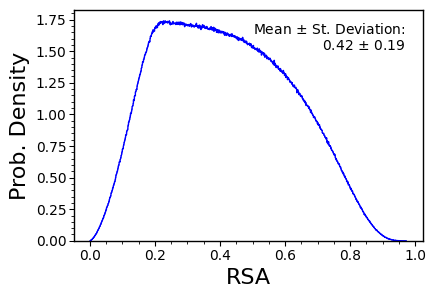

In [62]:

fig,ax = plt.subplots(figsize=(4.5,3))
print('use select and replace all to change property')


ax.hist(protein_df.RSA.values,
           histtype='step',bins=np.arange(protein_df.RSA.min(),protein_df.RSA.max(),0.001),
        color='blue',density = True, label = 'RSA')


ax.set_xlabel('RSA',fontsize=16)
ax.set_ylabel('Prob. Density',fontsize=16)
#ax.set_ylabel(r'$R_g\left/R_g^{theta}\right.$')
ax.text(0.97, 0.95, f'Mean $\pm$ St. Deviation:\n{format(protein_df.RSA.mean(),"0.2f")} $\pm$ {format(protein_df.RSA.std(),"0.2f")}',
        color='black', verticalalignment='top', horizontalalignment='right', transform=ax.get_xaxis_transform())

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
plt.savefig('figures_for_paper/Entire_IDRome_RSA_histogram.png',format='png',
           dpi=1000,bbox_inches='tight')

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_406869/1912058860.py:11: SyntaxWarning: invalid escape sequence '\p'
  ax.text(20, 0.95, f'Mean $\pm$ St. Deviation:\n{format(protein_df.ratio.mean(),"0.2f")} $\pm$ {format(protein_df.ratio.std(),"0.2f")}',
/tmp/ipykernel_406869/1912058860.py:11: SyntaxWarning: invalid escape sequence '\p'
  ax.text(20, 0.95, f'Mean $\pm$ St. Deviation:\n{format(protein_df.ratio.mean(),"0.2f")} $\pm$ {format(protein_df.ratio.std(),"0.2f")}',


use select and replace all to change property


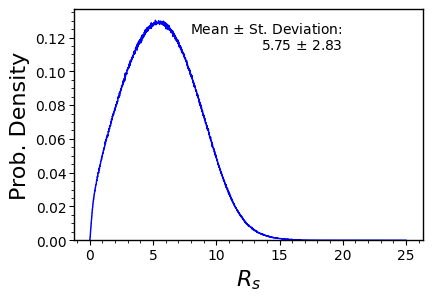

In [63]:

fig,ax = plt.subplots(figsize=(4.5,3))
print('use select and replace all to change property')

ax.hist(protein_df.ratio.values,
           histtype='step',bins=np.arange(protein_df.ratio.min(),protein_df.ratio.max(),0.01),
        color='blue',density = True)

ax.set_xlabel('$R_s$',fontsize=16)
ax.set_ylabel('Prob. Density',fontsize=16)
#ax.set_ylabel(r'$R_g\left/R_g^{theta}\right.$')
ax.text(20, 0.95, f'Mean $\pm$ St. Deviation:\n{format(protein_df.ratio.mean(),"0.2f")} $\pm$ {format(protein_df.ratio.std(),"0.2f")}',
        color='black', verticalalignment='top', horizontalalignment='right', transform=ax.get_xaxis_transform())

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
plt.savefig('figures_for_paper/Entire_IDRome_Rs_histogram.png',format='png',
           dpi=1000,bbox_inches='tight')

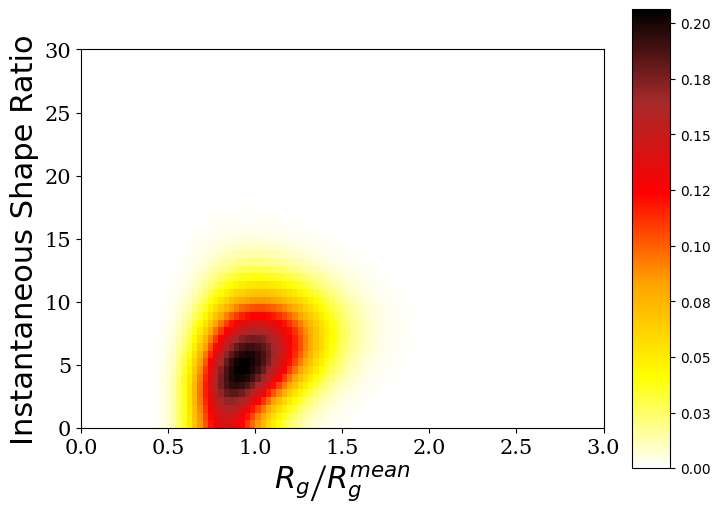

In [18]:

# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable=r'$R_g\left/R_g^{mean}\right.$'
y_variable="Instantaneous Shape Ratio"


x = protein_df['Rg/Rg_mean']
y = protein_df['ratio']

 
# Set up default x and y limits
xlims = [0,3]
ylims = [0,30]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=3)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
       interpolation='nearest', origin='lower',aspect=aspectratio))

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
#ONLY epas=0 data HERE  

# axHistx.hist([testeq_RW[x_variable].values,
#              testeq_RW[x_variable].values,
#              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
#              label=['RW: All Chain Lengths',
#                    'RW: All Chain Lengths',
#                    'salmon'],density=True)


#axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
#            label='GW',alpha=0.5,density=True)

#axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
#            label='GW',orientation='horizontal',alpha=0.5,density=True)

#axHistx.legend()
#axHisty.legend()

#axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
    
    
#Set up the histogram limits
#axHistx.set_xlim( min(x), max(x) )
#axHisty.set_ylim( min(y), max(y) )

# axHistx.set_xlim( 1,1.8)
# axHisty.set_ylim( ylims )

 
#Make the tickmarks pretty
# ticklabels = axHistx.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')

# #Make the tickmarks pretty    
# ticklabels = axHistx.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')    
 
# #Make the tickmarks pretty
# ticklabels = axHisty.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
# #Make the tickmarks pretty
# ticklabels = axHisty.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
    
 
#Cool trick that changes the number of tickmarks for the histogram axes
# axHisty.xaxis.set_major_locator(MaxNLocator(4))
# axHistx.yaxis.set_major_locator(MaxNLocator(4))

# axHistx.axes.get_xaxis().set_visible(False)
# axHisty.axes.get_yaxis().set_visible(False)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')


CPU times: user 35.2 s, sys: 1.33 s, total: 36.5 s
Wall time: 36.7 s


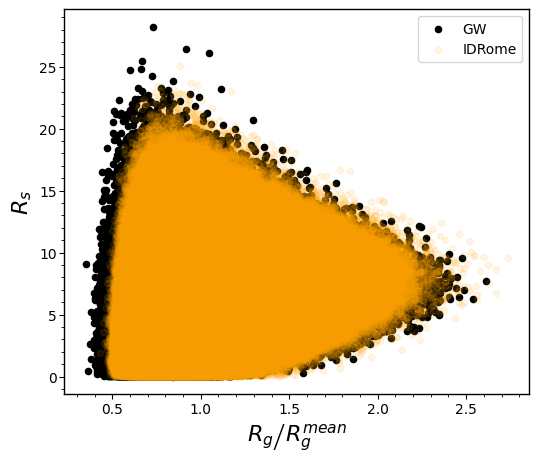

In [38]:
%%time
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(6,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['Rg/Rg_mean'],
           testeq_GW['ratio'],s=20,
                color='black',label='GW')

ax.scatter(protein_df['Rg/Rg_mean'],
           protein_df['ratio'],s=20,alpha=0.1,
                color='orange',label='IDRome')

ax.set_xlabel(r'$R_g\left/R_g^{mean}\right.$',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right',fontsize=10)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW

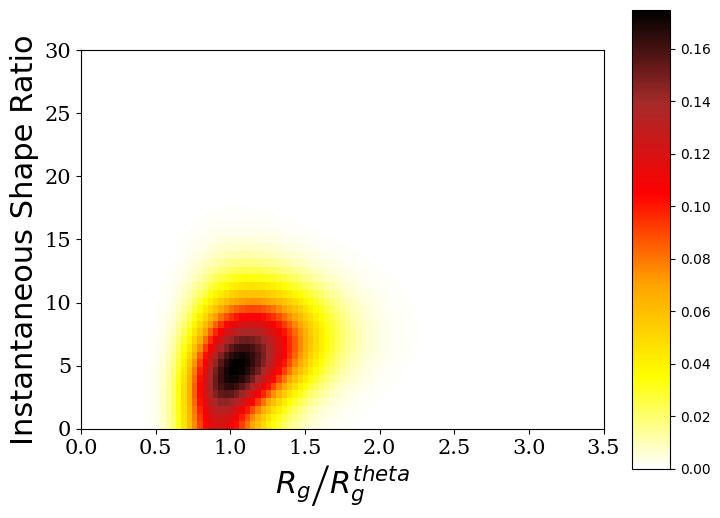

In [19]:

# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable=r'$R_g\left/R_g^{theta}\right.$'
y_variable="Instantaneous Shape Ratio"


x = protein_df['Rg/Rg_theta']
y = protein_df['ratio']

 
# Set up default x and y limits
xlims = [0,3.5]
ylims = [0,30]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=3)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
       interpolation='nearest', origin='lower',aspect=aspectratio))

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
#ONLY epas=0 data HERE  

# axHistx.hist([testeq_RW[x_variable].values,
#              testeq_RW[x_variable].values,
#              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
#              label=['RW: All Chain Lengths',
#                    'RW: All Chain Lengths',
#                    'salmon'],density=True)


#axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
#            label='GW',alpha=0.5,density=True)

#axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
#            label='GW',orientation='horizontal',alpha=0.5,density=True)

#axHistx.legend()
#axHisty.legend()

#axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
    
    
#Set up the histogram limits
#axHistx.set_xlim( min(x), max(x) )
#axHisty.set_ylim( min(y), max(y) )

# axHistx.set_xlim( 1,1.8)
# axHisty.set_ylim( ylims )

 
#Make the tickmarks pretty
# ticklabels = axHistx.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')

# #Make the tickmarks pretty    
# ticklabels = axHistx.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')    
 
# #Make the tickmarks pretty
# ticklabels = axHisty.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
# #Make the tickmarks pretty
# ticklabels = axHisty.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
    
 
#Cool trick that changes the number of tickmarks for the histogram axes
# axHisty.xaxis.set_major_locator(MaxNLocator(4))
# axHistx.yaxis.set_major_locator(MaxNLocator(4))

# axHistx.axes.get_xaxis().set_visible(False)
# axHisty.axes.get_yaxis().set_visible(False)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')


CPU times: user 34 s, sys: 1.28 s, total: 35.3 s
Wall time: 35.4 s


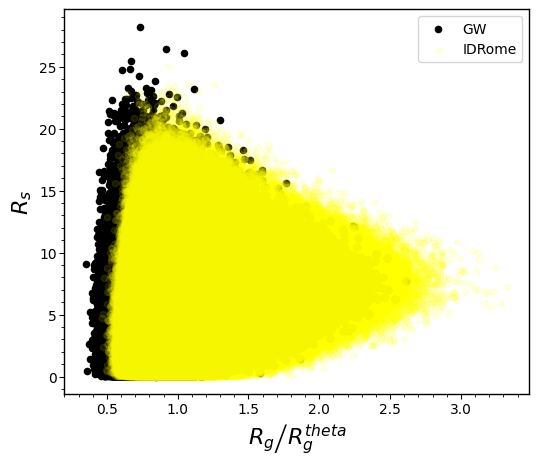

In [37]:
%%time
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(6,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['Rg/Rg_mean'],
           testeq_GW['ratio'],s=20,
                color='black',label='GW')

ax.scatter(protein_df['Rg/Rg_theta'],
           protein_df['ratio'],s=20,alpha=0.1,
                color='yellow',label='IDRome')

ax.set_xlabel(r'$R_g\left/R_g^{theta}\right.$',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW

In [19]:
%%time
merged_df2 = pd.merge(protein_df, idrome_prop_flucs, on='seq_name', how='left')

CPU times: user 7.3 s, sys: 5.15 s, total: 12.5 s
Wall time: 12.5 s


In [20]:
merged_df2

,seq_name,Rg2,Ree2,Rg,Rg/Rg_theta,Rg/Rg_mean,ratio,RSA,UniProt_ID,N,...,fI,fL,fM,fN,fQ,fS,fT,fV,fW,fY
0,H0YL14_1_46,3.434747,21.406586,1.853307,1.090439,0.979697,6.232362,0.628894,H0YL14,46,...,0.043478,0.043478,0.043478,0.043478,0.000000,0.043478,0.065217,0.086957,0.000000,0.043478
1,H0YL14_1_46,2.692158,19.995808,1.640780,0.965393,0.867351,7.427426,0.215764,H0YL14,46,...,0.043478,0.043478,0.043478,0.043478,0.000000,0.043478,0.065217,0.086957,0.000000,0.043478
2,H0YL14_1_46,2.406818,4.951129,1.551392,0.912800,0.820099,2.057127,0.279548,H0YL14,46,...,0.043478,0.043478,0.043478,0.043478,0.000000,0.043478,0.065217,0.086957,0.000000,0.043478
3,H0YL14_1_46,2.940652,30.779821,1.714833,1.008964,0.906497,10.467004,0.279988,H0YL14,46,...,0.043478,0.043478,0.043478,0.043478,0.000000,0.043478,0.065217,0.086957,0.000000,0.043478
4,H0YL14_1_46,3.827115,7.074895,1.956301,1.151038,1.034142,1.848624,0.529478,H0YL14,46,...,0.043478,0.043478,0.043478,0.043478,0.000000,0.043478,0.065217,0.086957,0.000000,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053995,A3KN83_666_850,21.559288,150.768280,4.643198,1.362314,1.287198,6.993194,0.702373,A3KN83,185,...,0.043243,0.059459,0.005405,0.075676,0.010811,0.178378,0.037838,0.016216,0.005405,0.010811
28053996,A3KN83_666_850,12.627858,127.334412,3.553570,1.042617,0.985128,10.083611,0.538784,A3KN83,185,...,0.043243,0.059459,0.005405,0.075676,0.010811,0.178378,0.037838,0.016216,0.005405,0.010811
28053997,A3KN83_666_850,11.513254,24.055033,3.393119,0.995541,0.940648,2.089334,0.248882,A3KN83,185,...,0.043243,0.059459,0.005405,0.075676,0.010811,0.178378,0.037838,0.016216,0.005405,0.010811
28053998,A3KN83_666_850,11.074450,71.702187,3.327830,0.976385,0.922548,6.474560,0.084178,A3KN83,185,...,0.043243,0.059459,0.005405,0.075676,0.010811,0.178378,0.037838,0.016216,0.005405,0.010811


/tmp/ipykernel_3734073/1492888812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.dropna(inplace=True)


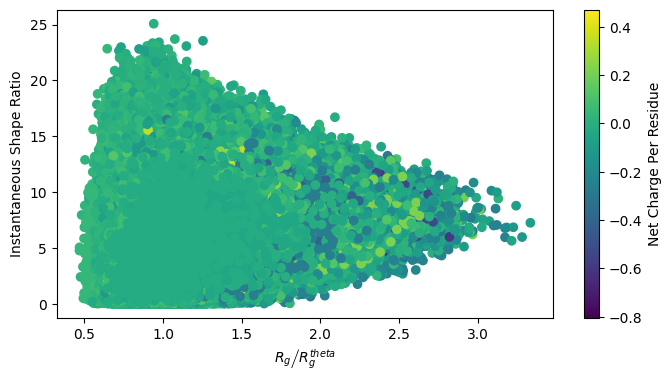

In [39]:
%%time


plot_data = merged_df2[['Rg/Rg_theta', 'ratio', 'net_charge']]

# Drop any rows with missing data to ensure the plot works without issues
plot_data.dropna(inplace=True)

# Create the scatter plot
plt.figure(figsize=(6, 4))
scatter = plt.scatter(plot_data['Rg/Rg_theta'], plot_data['ratio'], c=plot_data['net_charge'], cmap='viridis',s=10,alpha=0.1)
plt.colorbar(scatter, label='Net Charge Per Residue')
plt.xlabel(r'$R_g\left/R_g^{theta}\right.$')
plt.ylabel('Instantaneous Shape Ratio')
plt.show()



In [21]:
%%time
merged_df3=merged_df2.sort_values(by='nu').copy()
del merged_df2

CPU times: user 11.2 s, sys: 6.57 s, total: 17.8 s
Wall time: 17.8 s


In [22]:
%%time
merged_nu_compact = merged_df3[merged_df3.nu<0.45].copy()
merged_nu_undefined = merged_df3[(merged_df3.nu>0.45) & (merged_df3.nu<0.55)].copy()
merged_nu_extended = merged_df3[ merged_df3.nu>0.55].copy()
del merged_df3

CPU times: user 4.11 s, sys: 2.85 s, total: 6.95 s
Wall time: 6.97 s


In [2]:
merged_nu_compact

NameError: name 'merged_nu_compact' is not defined

this is only for nu < 0.45, ylim and vmin/vmax MANUALLY entered, first 300000 snapshots


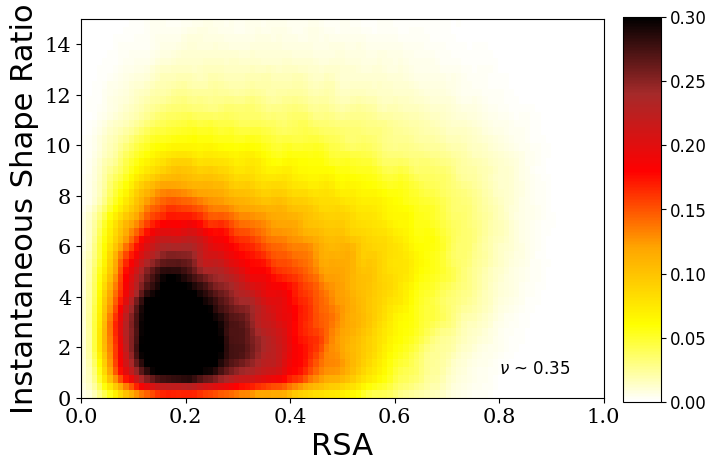

In [28]:
print('this is only for nu < 0.45, ylim and vmin/vmax MANUALLY entered, first 300000 snapshots')
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"

test_df = merged_nu_compact[['RSA','ratio','nu']].iloc[:300000,:].copy()
x = test_df['RSA']
y = test_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.text(0.8, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
                   fontsize=12,
        transform=axTemperature.get_xaxis_transform())
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)

 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([left+width+0.02, bottom+0.06, 0.04, height-0.122])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))
cbar_ax.tick_params(labelsize=12)

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig('heatmap_complete_inst_conf_landscape_nu_compact.png', dpi = 1000, bbox_inches='tight')
del test_df


this is only for  0.45 < nu < 0.55, ylim and vmin/vmax MANUALLY entered, MIDDLE 300000 snapshots


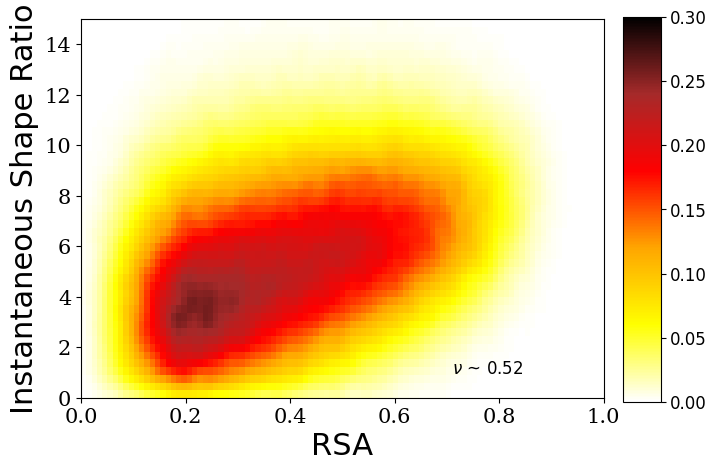

In [29]:
print('this is only for  0.45 < nu < 0.55, ylim and vmin/vmax MANUALLY entered, MIDDLE 300000 snapshots')
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"


test_df = merged_nu_undefined[['RSA','ratio','nu']].copy()
total_rows = test_df.shape[0]
start_row = (total_rows // 2) - 150000  
end_row = start_row + 300000
test_df = test_df.iloc[start_row:end_row,:]
x = test_df['RSA']
y = test_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.text(0.7, 0.1, f' $\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
                   fontsize=12,
        transform=axTemperature.get_xaxis_transform())
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)

 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([left+width+0.02, bottom+0.06, 0.04, height-0.122])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))
cbar_ax.tick_params(labelsize=12)

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig('heatmap_complete_inst_conf_landscape_nu_undefined.png', dpi = 1000, bbox_inches='tight')
del test_df

this is only for nu > 0.55, ylim and vmin/vmax MANUALLY entered, last 300000 snapshots


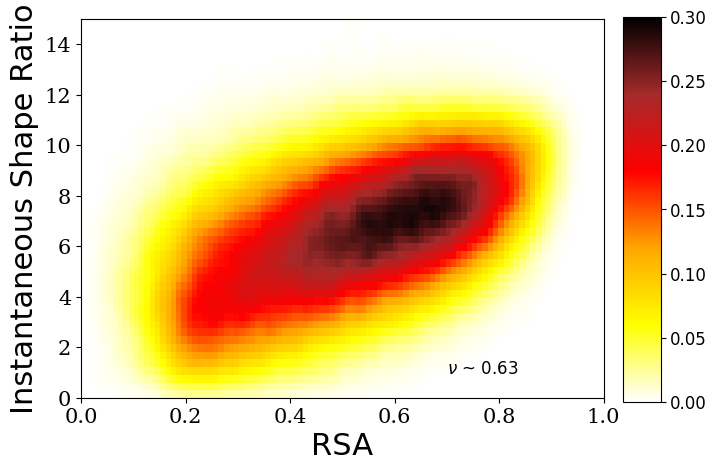

In [30]:
print('this is only for nu > 0.55, ylim and vmin/vmax MANUALLY entered, last 300000 snapshots')
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"

test_df = merged_nu_extended[['RSA','ratio','nu']].iloc[-300000:,:].copy()
x = test_df['RSA']
y = test_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.text(0.7, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
                   fontsize=12,
        transform=axTemperature.get_xaxis_transform())
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)

 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([left+width+0.02, bottom+0.06, 0.04, height-0.122])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))
cbar_ax.tick_params(labelsize=12)

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig('heatmap_complete_inst_conf_landscape_nu_extended.png', dpi = 1000, bbox_inches='tight')
del test_df

In [46]:
idrome_prop_flucs[idrome_prop_flucs.net_charge<0.05].seq_name.unique().shape

(21752,)

ONLY low ncpr
this is only for nu < 0.45, ylim and vmin/vmax MANUALLY entered, first 300000 snapshots


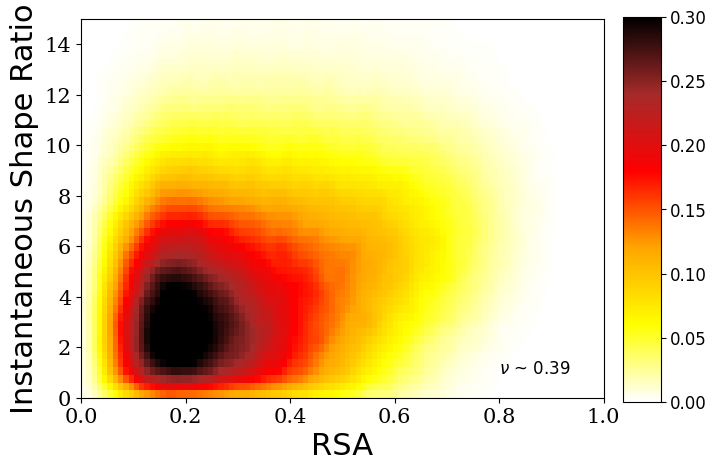

In [47]:
print('ONLY low ncpr')
print('this is only for nu < 0.45, ylim and vmin/vmax MANUALLY entered, first 300000 snapshots')
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"

test_df = merged_nu_compact[merged_nu_compact.net_charge<0.05]
test_df = test_df[['RSA','ratio','nu']].copy()

x = test_df['RSA']
y = test_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.text(0.8, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
                   fontsize=12,
        transform=axTemperature.get_xaxis_transform())
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)

 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([left+width+0.02, bottom+0.06, 0.04, height-0.122])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))
cbar_ax.tick_params(labelsize=12)

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig('heatmap_complete_inst_conf_landscape_nu_compact.png', dpi = 1000, bbox_inches='tight')
del test_df


ONLY low ncpr
this is only for  0.45 < nu < 0.55, ylim and vmin/vmax MANUALLY entered, MIDDLE 300000 snapshots


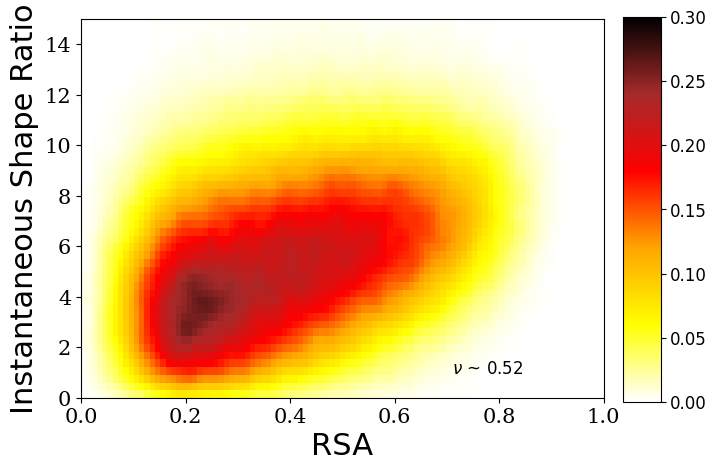

In [48]:
print('ONLY low ncpr')
print('this is only for  0.45 < nu < 0.55, ylim and vmin/vmax MANUALLY entered, MIDDLE 300000 snapshots')
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"

test_df = merged_nu_undefined[merged_nu_undefined.net_charge<0.05]
test_df = test_df[['RSA','ratio','nu']].copy()
total_rows = test_df.shape[0]
start_row = (total_rows // 2) - 150000  
end_row = start_row + 300000
test_df = test_df.iloc[start_row:end_row,:]
x = test_df['RSA']
y = test_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.text(0.7, 0.1, f' $\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
                   fontsize=12,
        transform=axTemperature.get_xaxis_transform())
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)

 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([left+width+0.02, bottom+0.06, 0.04, height-0.122])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))
cbar_ax.tick_params(labelsize=12)

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig('heatmap_complete_inst_conf_landscape_nu_undefined.png', dpi = 1000, bbox_inches='tight')
del test_df

ONLY low ncpr
this is only for nu > 0.55, ylim and vmin/vmax MANUALLY entered, last 300000 snapshots


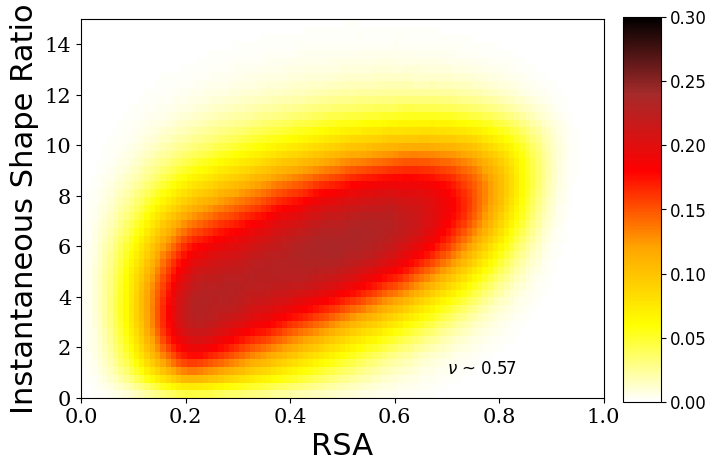

In [49]:
print('ONLY low ncpr')
print('this is only for nu > 0.55, ylim and vmin/vmax MANUALLY entered, last 300000 snapshots')
# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"

test_df = merged_nu_extended[merged_nu_extended.net_charge<0.05]
test_df = test_df[['RSA','ratio','nu']].copy()
x = test_df['RSA']
y = test_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    

palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.text(0.7, 0.1, f'$\\nu$ ~ {format(test_df.nu.mean(),"0.2f")}', color='black', verticalalignment='top', horizontalalignment='left',
                   fontsize=12,
        transform=axTemperature.get_xaxis_transform())
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)

 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([left+width+0.02, bottom+0.06, 0.04, height-0.122])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))
cbar_ax.tick_params(labelsize=12)

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig('heatmap_complete_inst_conf_landscape_nu_extended.png', dpi = 1000, bbox_inches='tight')
del test_df

In [36]:
idrome_prop_flucs[[f'f{aaa}' for aaa in unique_amino_acids_list]+['fcr']+['N']]

,fA,fC,fD,fE,fF,fG,fH,fI,fK,fL,...,fP,fQ,fR,fS,fT,fV,fW,fY,fcr,N
0,0.108108,0.027027,0.027027,0.000000,0.027027,0.081081,0.000000,0.000000,0.027027,0.108108,...,0.108108,0.027027,0.027027,0.162162,0.081081,0.081081,0.000000,0.000000,0.054054,37
1,0.031250,0.000000,0.000000,0.031250,0.093750,0.125000,0.062500,0.031250,0.000000,0.250000,...,0.031250,0.000000,0.125000,0.062500,0.000000,0.031250,0.062500,0.000000,0.187500,32
2,0.134328,0.089552,0.014925,0.134328,0.014925,0.059701,0.029851,0.074627,0.044776,0.089552,...,0.044776,0.000000,0.074627,0.059701,0.029851,0.044776,0.014925,0.000000,0.283582,67
3,0.053030,0.007576,0.022727,0.068182,0.045455,0.060606,0.022727,0.037879,0.053030,0.106061,...,0.060606,0.045455,0.053030,0.083333,0.060606,0.068182,0.015152,0.045455,0.212121,132
4,0.195652,0.021739,0.043478,0.000000,0.000000,0.043478,0.021739,0.065217,0.086957,0.021739,...,0.108696,0.065217,0.086957,0.086957,0.021739,0.065217,0.000000,0.021739,0.239130,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,0.104972,0.066298,0.027624,0.027624,0.016575,0.104972,0.060773,0.016575,0.022099,0.055249,...,0.093923,0.038674,0.093923,0.082873,0.038674,0.071823,0.027624,0.000000,0.182320,181
28054,0.122047,0.035433,0.027559,0.003937,0.015748,0.204724,0.003937,0.011811,0.023622,0.055118,...,0.055118,0.007874,0.122047,0.102362,0.035433,0.078740,0.062992,0.003937,0.185039,254
28055,0.027523,0.009174,0.073394,0.055046,0.027523,0.211009,0.018349,0.073394,0.100917,0.110092,...,0.064220,0.036697,0.036697,0.036697,0.036697,0.027523,0.000000,0.000000,0.275229,109
28056,0.035398,0.044248,0.053097,0.088496,0.044248,0.061947,0.026549,0.053097,0.061947,0.132743,...,0.017699,0.035398,0.053097,0.123894,0.053097,0.026549,0.008850,0.017699,0.274336,113


use this for manual verification of complete bar plot


Text(0, 0.5, 'E')

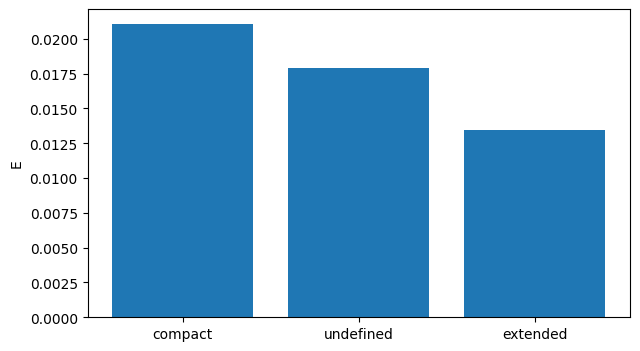

In [69]:
print('use this for manual verification of complete bar plot')
test_df1 = merged_nu_compact[merged_nu_compact.net_charge<0.05]
test_df1 = np.sum(test_df1.fY.values*test_df1.N.values)/np.sum(test_df1.N.values)

test_df2 = merged_nu_undefined[merged_nu_undefined.net_charge<0.05]
test_df2 = np.sum(test_df2.fY.values*test_df2.N.values)/np.sum(test_df2.N.values)

test_df3 = merged_nu_extended[merged_nu_extended.net_charge<0.05]
test_df3 = np.sum(test_df3.fY.values*test_df3.N.values)/np.sum(test_df3.N.values)

# Plotting the frequencies with colored bars
plt.figure(figsize=(7, 4))
bars = plt.bar(['compact','undefined','extended'], [test_df1,test_df2,test_df3])




#plt.legend(handles=legend_elements, loc='upper center', title='Residue Properties')

#plt.xlabel('Amino Acid')  
plt.ylabel('E')  



In [ ]:
def get_aa_shape_freqs(shape,merged_nu_compact, merged_nu_undefined, merged_nu_extended,unique_amino_acids_list):

    data_slices = [merged_nu_compact, merged_nu_undefined, merged_nu_extended]
    frequencies = []
    if shape == 'compact':
        for i, amino_acid in enumerate(unique_amino_acids_list):
            filtered_data = data_slices[0][data_slices[0].net_charge < 0.05]
            frequency = np.sum(filtered_data[f'f{amino_acid}'].values * filtered_data.N.values) / np.sum(filtered_data.N.values)
            frequencies.append(frequency)
        return frequencies
    elif shape == 'undefined':
        for i, amino_acid in enumerate(unique_amino_acids_list):
            filtered_data = data_slices[1][data_slices[1].net_charge < 0.05]
            frequency = np.sum(filtered_data[f'f{amino_acid}'].values * filtered_data.N.values) / np.sum(filtered_data.N.values)
            frequencies.append(frequency)
        return frequencies
    elif shape == 'extended':
        for i, amino_acid in enumerate(unique_amino_acids_list):
            filtered_data = data_slices[2][data_slices[2].net_charge < 0.05]
            frequency = np.sum(filtered_data[f'f{amino_acid}'].values * filtered_data.N.values) / np.sum(filtered_data.N.values)
            frequencies.append(frequency)
        return frequencies        

CPU times: user 44.4 s, sys: 25.5 s, total: 1min 9s
Wall time: 1min 10s


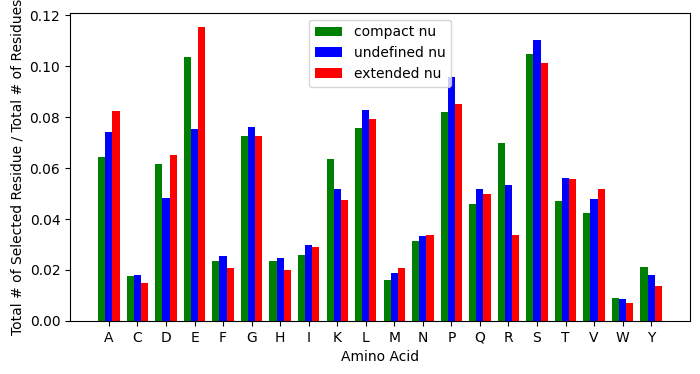

In [68]:
%%time
categories = ['compact', 'undefined', 'extended']
data_slices = [merged_nu_compact, merged_nu_undefined, merged_nu_extended]
colors = ['green', 'blue', 'red']


# Plot settings
plt.figure(figsize=(8, 4))
n = len(unique_amino_acids_list)  # Number of amino acids
width = 0.25  # Width of the bars

# Generate the grouped bar plots
for i, category in enumerate(categories):
    
    offsets = np.arange(n) + i * width
    plt.bar(offsets, get_aa_shape_freqs(category,merged_nu_compact, merged_nu_undefined, merged_nu_extended,unique_amino_acids_list),
            width, color=colors[i], label=category+' nu')

# Setting x-ticks and x-labels in the middle of the group
plt.xticks(np.arange(n) + width, unique_amino_acids_list)

plt.xlabel('Amino Acid')
plt.ylabel('Total # of Selected Residue / Total # of Residues')
plt.legend(loc='upper center')


CPU times: user 7min 31s, sys: 3.04 s, total: 7min 34s
Wall time: 7min 35s


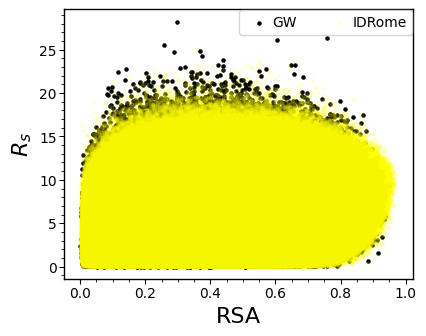

In [66]:
%%time
testeq_GW = pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(4.5,3.5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['RSA'],
           testeq_GW['ratio'],s=5,
                color='black',label='GW')

ax.scatter(protein_df['RSA'],
           protein_df['ratio'],s=5,alpha=0.1,
                color='yellow',label='IDRome')

ax.set_xlabel('RSA',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right', fontsize=10,handletextpad=0.005,borderaxespad = 0.05,ncols=2)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW
plt.savefig('figures_for_paper/Rs_RSA_GW_IDRome.png',format='png',
           dpi=1000,bbox_inches='tight')

CPU times: user 34.8 s, sys: 913 ms, total: 35.7 s
Wall time: 35.8 s


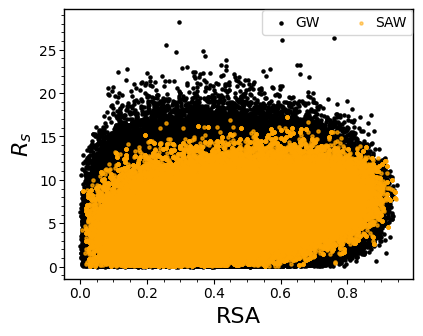

In [35]:
%%time
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean

fig,ax = plt.subplots(figsize=(4.5,3.5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

ax.scatter(testeq_GW['RSA'],
           testeq_GW['ratio'],s=5,
                color='black',label='GW')

ax.scatter(SAW_equil[SAW_equil.epas==0]['RSA'],
           SAW_equil[SAW_equil.epas==0]['ratio'],s=5,alpha=0.5,
                color='orange',label='SAW')

ax.set_xlabel('RSA',fontsize=16 )
ax.set_ylabel('$R_s$',fontsize=16)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.legend(loc='upper right',fontsize=10,ncols=2,handletextpad=0.005,borderaxespad = 0.05)
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)
del testeq_GW


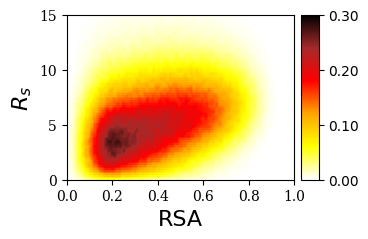

In [55]:
# Define the x and y data 
# For example just using random numbers

testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
GW_rg = testeq_GW['Rg2']**0.5
GW_rg_mean = GW_rg.mean()
GW_rg_by_rg_mean = GW_rg/GW_rg_mean
testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean


x_variable='RSA'
y_variable=r"$R_s$"


x = testeq_GW['RSA']
y = testeq_GW['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(4.5,3))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 200
nybins = 100
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=16)
axTemperature.set_ylabel(ylabel,fontsize=16)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.68)
cbar_ax = fig.add_axes([left+width-0.008, bottom, 0.04, height])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
del testeq_GW
plt.savefig('figures_for_paper/GW_only_Rs_RSA_heatmap.png',format='png',
           dpi=1000,bbox_inches='tight')

In [21]:
testeq_GW[['ratio','RSA','Rg2']].corr(method='pearson')

,ratio,RSA,Rg2
ratio,1.000000,0.268748,0.225532
RSA,0.268748,1.000000,0.675043
Rg2,0.225532,0.675043,1.000000


In [28]:
protein_df[['ratio','RSA','Rg/Rg_mean']].corr(method='pearson')

,ratio,RSA,Rg/Rg_mean
ratio,1.000000,0.350987,0.334402
RSA,0.350987,1.000000,0.750880
Rg/Rg_mean,0.334402,0.750880,1.000000


entire IDRome
CPU times: user 2.9 s, sys: 870 ms, total: 3.77 s
Wall time: 3.4 s


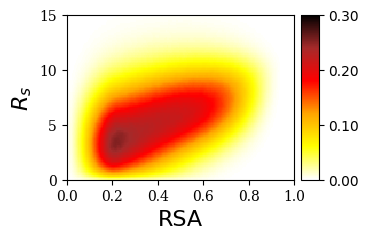

In [61]:
%%time
# Define the x and y data 

print('entire IDRome')

x_variable='RSA'
y_variable=r"$R_s$"


x = protein_df['RSA']
y = protein_df['ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,15]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(4.5,3))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 200
nybins = 100
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=1)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])    
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,vmin=0,vmax=0.3,
       interpolation='nearest', origin='lower',aspect=aspectratio))

 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=16)
axTemperature.set_ylabel(ylabel,fontsize=16)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(10)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.68)
cbar_ax = fig.add_axes([left+width-0.008, bottom, 0.04, height])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
plt.savefig('figures_for_paper/Entire_IDRome_Rs_RSA_heatmap.png',format='png',
           dpi=1000,bbox_inches='tight')